In [1]:
import torch
import torchvision

from models import LFADS
from utils import read_data, load_parameters, save_parameters, batchify_random_sample

np = torch._np
import matplotlib.pyplot as plt
import yaml
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


In [3]:
seed = 250
if os.path.exists('./synth_data/lorenz_%s'%seed):
    data_dict = read_data('./synth_data/lorenz_%s'%seed)
else:
    from synthetic_data import generate_lorenz_data
    data_dict = generate_lorenz_data(N_cells=30, N_inits=65, N_trials=20, N_steps=200, N_stepsinbin=2, dt_lorenz=0.015, dt_spike = 1./20, base_firing_rate= 1.0, save=True, seed=250)

# For spike data
train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = {'rates'  : data_dict['train_rates'],
               'latent' : data_dict['train_latent']}

valid_truth = {'rates'  : data_dict['valid_rates'],
               'latent' : data_dict['valid_latent']}

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape;
print(train_data.shape);
print('Number of datapoints = %s'%train_data.numel())

torch.Size([1040, 100, 30])
Number of datapoints = 3120000


In [4]:
hyperparams = load_parameters('./parameters/parameters_lorenz_spikes.yaml')
hyperparams['run_name'] += '_jittest'
save_parameters(hyperparams, path=None)

hyperparams

{'betas': (0.9, 0.99),
 'clip_val': 5.0,
 'dataset_name': 'lorenz',
 'datatype': 'spikes',
 'epsilon': 0.1,
 'factors_dim': 3,
 'g0_encoder_dim': 64,
 'g0_prior_kappa': 0.1,
 'g0_prior_var_max': 0.1,
 'g0_prior_var_min': 0.1,
 'g_dim': 64,
 'keep_prob': 0.95,
 'kernel_dim': 20,
 'kl_weight_min': 0.0,
 'kl_weight_schedule_dur': 1600,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 250,
 'l2_weight_min': 0.0,
 'l2_weight_schedule_dur': 1600,
 'l2_weight_schedule_start': 0.0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'norm_factors': True,
 'run_name': 'poisson_jittest',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 0,
 'u_prior_kappa': 0.1,
 'use_weight_schedule_fn': True}

In [5]:
model = LFADS(inputs_dim = num_cells, T = num_steps, dt = float(data_dict['dt']), device=device, use_jit=True,
              model_hyperparams=hyperparams).to(device)

Random seed: 5113


In [6]:
model.load_checkpoint('recent')

In [7]:
model.fit(train_ds, valid_ds, train_truth=train_truth, valid_truth=valid_truth,
          max_epochs=2000, batch_size=65, use_tensorboard=False, health_check=False)

Beginning training...


RuntimeError: 
dim() called on undefined Tensor (dim at /opt/conda/conda-bld/pytorch_1556653145446/work/c10/core/UndefinedTensorImpl.cpp:24)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x45 (0x7ff88d2c6dc5 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libc10.so)
frame #1: c10::UndefinedTensorImpl::dim() const + 0x6f (0x7ff88d2bfecf in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x7d3f8a (0x7ff88dcb3f8a in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libcaffe2.so)
frame #3: at::native::cat(c10::ArrayRef<at::Tensor>, long) + 0x3a (0x7ff88dcbf24a in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libcaffe2.so)
frame #4: at::TypeDefault::cat(c10::ArrayRef<at::Tensor>, long) const + 0x4f (0x7ff88df765bf in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libcaffe2.so)
frame #5: <unknown function> + 0x993a72 (0x7ff88b1eda72 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch.so.1)
frame #6: <unknown function> + 0xa73df8 (0x7ff88b2cddf8 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch.so.1)
frame #7: torch::jit::InterpreterState::run(std::vector<c10::IValue, std::allocator<c10::IValue> >&) + 0x22 (0x7ff88b2c9372 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch.so.1)
frame #8: <unknown function> + 0xa5b2d9 (0x7ff88b2b52d9 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch.so.1)
frame #9: <unknown function> + 0xa567b6 (0x7ff88b2b07b6 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch.so.1)
frame #10: <unknown function> + 0x307622 (0x7ff88ab61622 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch.so.1)
frame #11: torch::autograd::Engine::evaluate_function(torch::autograd::FunctionTask&) + 0x385 (0x7ff88ab5a745 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch.so.1)
frame #12: torch::autograd::Engine::thread_main(torch::autograd::GraphTask*) + 0xc0 (0x7ff88ab5c740 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch.so.1)
frame #13: torch::autograd::Engine::thread_init(int) + 0x2b0 (0x7ff88ab599e0 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch.so.1)
frame #14: torch::autograd::python::PythonEngine::thread_init(int) + 0x2a (0x7ff8b330cd1a in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/torch/lib/libtorch_python.so)
frame #15: <unknown function> + 0xb8678 (0x7ff8de296678 in /home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #16: <unknown function> + 0x76db (0x7ff8e4f956db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #17: clone + 0x3f (0x7ff8e4cbe88f in /lib/x86_64-linux-gnu/libc.so.6)
:
operation failed in interpreter:
                grad_self = grad_output.reshape(self_size)
                return grad_self, None

            return torch.reshape(self, shape), backward

        def split(self,
                  split_size: int,
                  dim: int):
            def backward(grad_outputs: List[Tensor]):
                grad_self = torch.cat(grad_outputs, dim)
                            ~~~~~~~~~ <--- HERE
                return grad_self, None, None

            return torch.split(self, split_size, dim), backward

        def split_with_sizes(self,
                             split_sizes: List[int],
                             dim: int=0):
            def backward(grad_outputs: List[Tensor]):
                size = len(grad_outputs)


In [7]:
model.load_checkpoint('best')

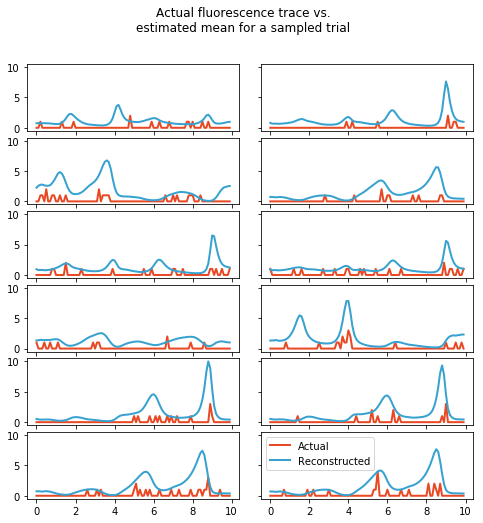

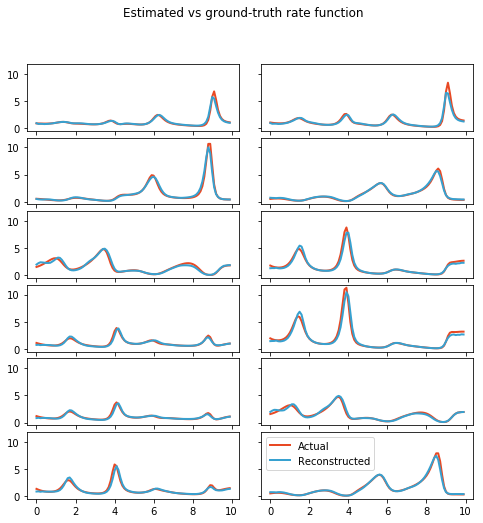

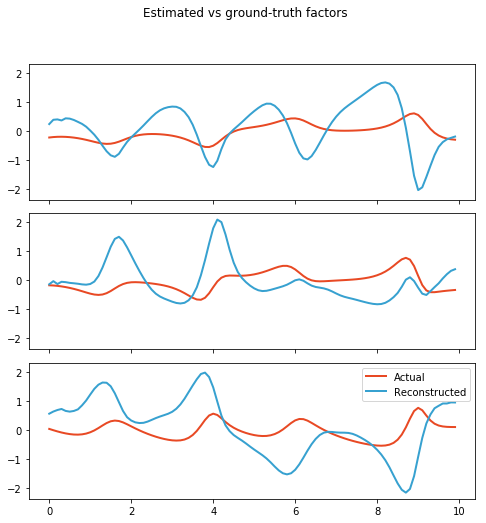

In [8]:
fig_dict = model.plot_summary(data=valid_data, truth=valid_truth)

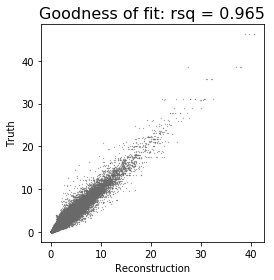

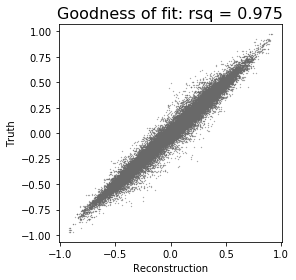

In [9]:
results_dict = model.plot_recon_rsquared(valid_data, valid_truth, train_data, train_truth)

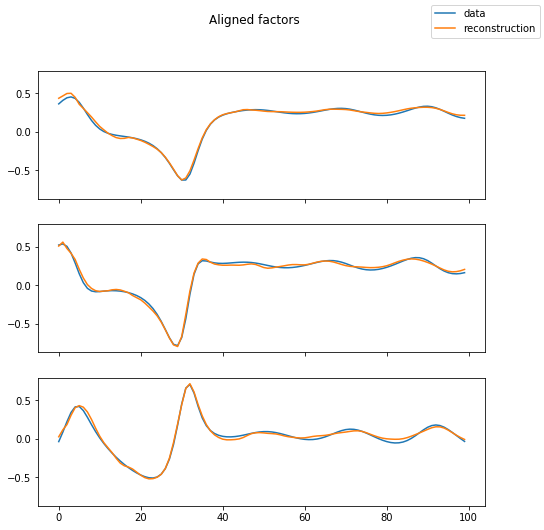

In [10]:
fig, axs = plt.subplots(figsize=(8,8), nrows=3, ncols=1, sharex=True, sharey=True)
for ix in range(3):
    plt.sca(axs[ix])
    plt.plot(data_dict['valid_latent'][0, :100, ix])
    plt.plot(results_dict['factors']['aligned'][:100, ix])
    
fig.suptitle('Aligned factors')
fig.legend(['data', 'reconstruction'])

## Inspecting trained Lorenz model 

In [3]:
seed = 250
if os.path.exists('./synth_data/lorenz_%s'%seed):
    data_dict = read_data('./synth_data/lorenz_%s'%seed)
else:
    from synthetic_data import generate_lorenz_data
    param_dict = yaml.load(open('./synth_data/lorenz_params.yaml', 'r'), Loader=yaml.FullLoader)
    data_dict = generate_lorenz_data(N_cells=param_dict['cells'],
                                     N_inits=param_dict['inits'],
                                     N_trials=param_dict['trials'],
                                     N_steps=param_dict['steps'],
                                     N_stepsinbin=param_dict['steps_in_bin'],
                                     dt_lorenz=param_dict['dt_sys'],
                                     dt_spike = param_dict['dt_spike'],
                                     base_firing_rate= param_dict['rate_scale'],
                                     save=False,
                                     seed=seed)

# For spike data
train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = {'rates'  : data_dict['train_rates'],
               'latent' : data_dict['train_latent']}

valid_truth = {'rates'  : data_dict['valid_rates'],
               'latent' : data_dict['valid_latent']}

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape;
print(train_data.shape);
print('Number of datapoints = %s'%train_data.numel())

torch.Size([1040, 100, 30])
Number of datapoints = 3120000


In [4]:
hyperparams = load_parameters('parameters/parameters_lorenz_spikes.yaml')
hyperparams['run_name'] = 'poisson_seed250_f3_g164_eg164_u0_191124'
model = LFADS(inputs_dim = num_cells, T = num_steps, dt = float(data_dict['dt']), device=device,
              model_hyperparams=hyperparams).to(device)

Random seed: 1173


In [5]:
model.load_checkpoint('best')
model.epochs

1257

{'ix': 477,
 'traces': <Figure size 576x576 with 12 Axes>,
 'truth_factors': <Figure size 576x576 with 3 Axes>,
 'truth_rates': <Figure size 576x576 with 12 Axes>}

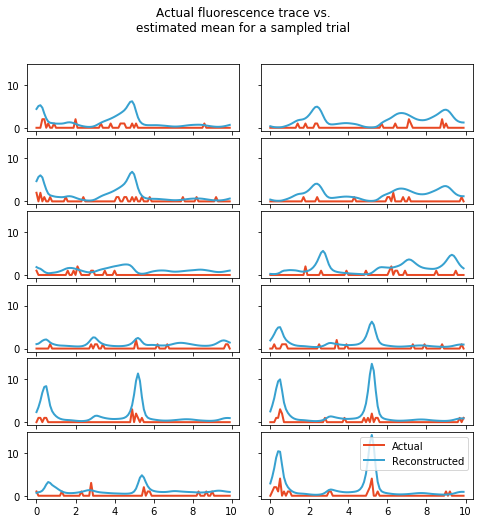

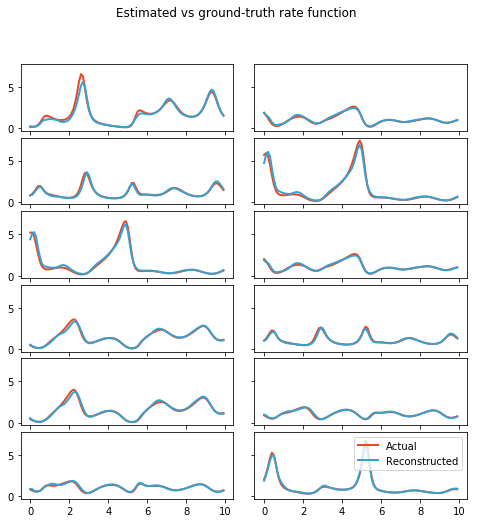

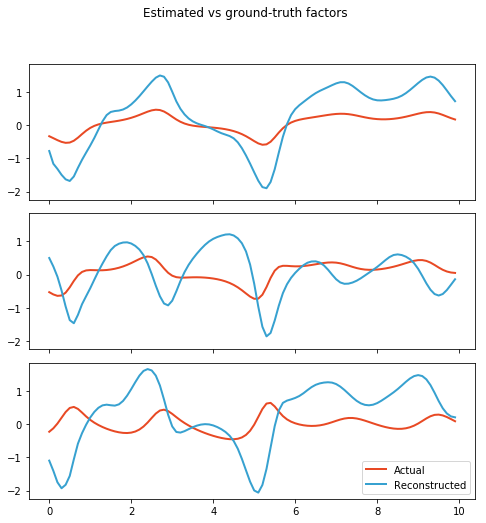

In [6]:
model.plot_summary(train_data, train_truth)

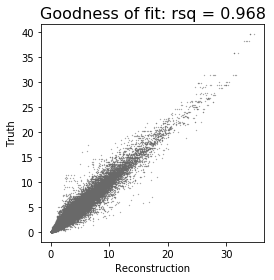

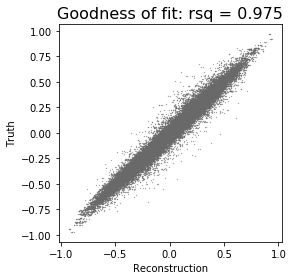

In [7]:
results_dict = model.plot_recon_rsquared(valid_data, valid_truth, train_data, train_truth)

## Inspecting trained Chaotic RNN model 

In [13]:
seed = 250
if os.path.exists('./synth_data/chaotic-rnn_%s'%seed):
    data_dict = read_data('./synth_data/chaotic-rnn_%s'%seed)
else:
    from synthetic_data import generate_chaotic_rnn_data
    param_dict = yaml.load(open('./synth_data/chaotic-rnn_params.yaml', 'r'), Loader=yaml.FullLoader)
    data_dict = generate_chaotic_rnn_data(N_cells=param_dict['cells'],
                                          N_inits=param_dict['inits'],
                                          N_trials=param_dict['trials'],
                                          N_steps=param_dict['steps'],
                                          N_stepsinbin=param_dict['steps_in_bin'],
                                          dt_lorenz=param_dict['dt_sys'],
                                          dt_spike = param_dict['dt_spike'],
                                          base_firing_rate= param_dict['rate_scale'],
                                          save=False,
                                          seed=seed)

# For spike data
train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = {'rates'  : data_dict['train_rates']}

valid_truth = {'rates'  : data_dict['valid_rates']}

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape;
print(train_data.shape);
print('Number of datapoints = %s'%train_data.numel())

torch.Size([3200, 100, 50])
Number of datapoints = 16000000


In [14]:
hyperparams = load_parameters('parameters/parameters_chaotic-rnn_spikes.yaml')
hyperparams['run_name'] = 'poisson_seed250_f20_g1200_eg1200_u1_c1128_ec1128_191124'
model = LFADS(inputs_dim = num_cells, T = num_steps, dt = float(data_dict['dt']), device=device,
              model_hyperparams=hyperparams).to(device)

Random seed: 8545


In [15]:
model.load_checkpoint('best')
model.epochs

1440

{'factors': <Figure size 576x576 with 20 Axes>,
 'inputs': <Figure size 576x108 with 1 Axes>,
 'ix': 1494,
 'traces': <Figure size 576x576 with 12 Axes>,
 'truth_rates': <Figure size 576x576 with 12 Axes>}

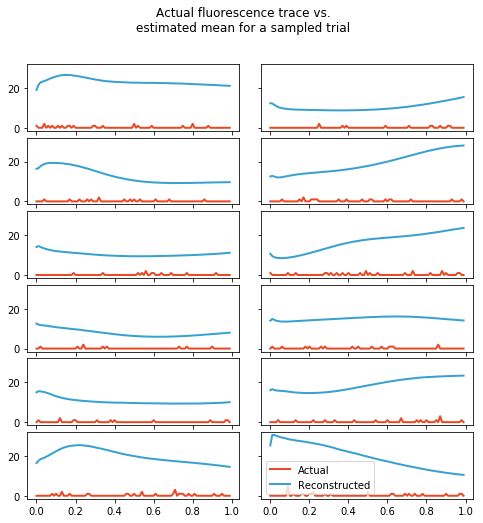

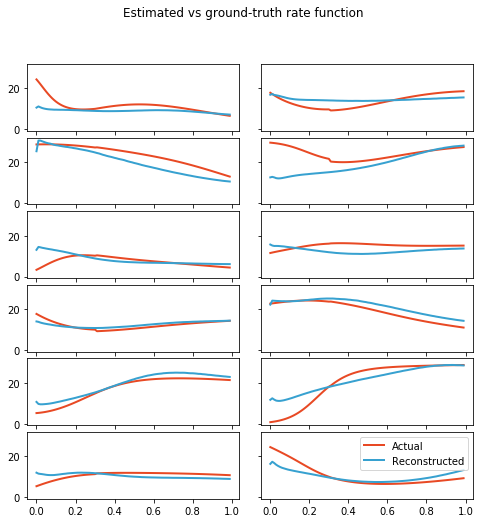

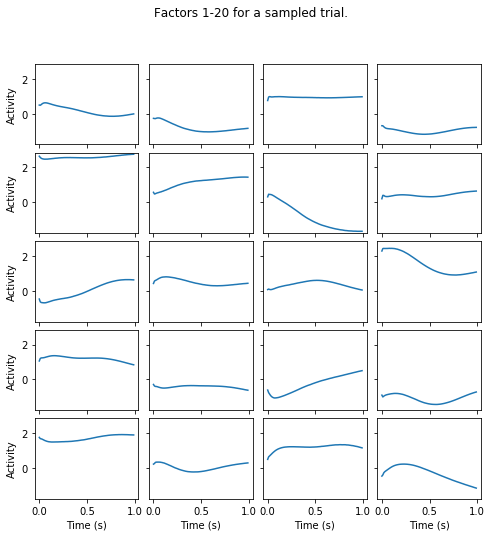

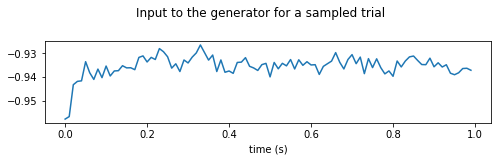

In [17]:
model.plot_summary(train_data, train_truth)

In [7]:
x = train_data[:65]
%timeit model(x)

85 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
model(x)
loss = model.recon_loss + model.kl_loss
import time
start = time.time()
loss.backward()
runtime = time.time() - start
print('%.4f s'%runtime)

0.0920 s


In [8]:
%timeit model.encode(x.permute(1, 0, 2))

4.42 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit model.generate(x.permute(1, 0, 2))

82.3 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit model.initialize_variables()

248 µs ± 3.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%timeit model.generate_one_step(0)

369 µs ± 4.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit model.compute_loss_one_step(x.permute(1, 0, 2), 0)

189 µs ± 3.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit model.compute_recon_loss_one_step(x.permute(1, 0, 2), 10)

191 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit model.compute_kl_loss_one_step(10)

172 ns ± 1.01 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [25]:
model.compute_recon_loss_one_step??

Signature: model.compute_recon_loss_one_step(x, t)
Source:   
    def compute_recon_loss_one_step(self, x, t):
        '''
        compute_recon_loss_one_step(x, t)
        
        Compute reconstruction loss for one time step and add to recon_loss of model
        
        Arguments:
            - x (torch.Tensor) : Single trial data
            - t (int) : time-step
        '''
        if t == -1:
            self.recon_loss = 0
        else:
            self.recon_loss = self.recon_loss - self.logLikelihood(x[t], self.r * self.dt)/self.batch_size
File:      ~/Documents/Projects/RichardsPostdoc/hierarchical_lfads/models.py
Type:      method


In [58]:
%timeit model.logLikelihood(x.permute(1, 0, 2)[10], model.r)

132 µs ± 652 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [56]:
inbuilt_ll = torch.nn.PoissonNLLLoss(log_input=True, full=False, reduction='sum', eps=1e-8)

In [57]:
%timeit inbuilt_ll(x.permute(1, 0, 2)[10], model.r)

81.2 µs ± 589 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
model.logLikelihood(x.permute(1, 0, 2)[10], model.r)

tensor(-2591.1741, device='cuda:0', grad_fn=<SumBackward0>)

In [53]:
-inbuilt_ll(x.permute(1, 0, 2)[10], model.r)

tensor(-3604.2859, device='cuda:0', grad_fn=<NegBackward>)

In [72]:
def logLikelihoodPoisson(k, lam):
    '''
    logLikelihoodPoisson(k, lam)

    Log-likelihood of Poisson distributed counts k given intensity lam.

    Arguments:
        - k (torch.Tensor): Tensor of size batch-size x time-step x input dimensions
        - lam (torch.Tensor): Tensor of size batch-size x time-step x input dimensions
    '''
    return (k * lam.log() - lam - torch.lgamma(k + 1)).sum()

In [63]:
%timeit logLikelihoodPoisson(x.permute(1, 0, 2)[10], model.r)

74.7 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [76]:
jit_ll = torch.jit.trace(LLPoisson(), example_inputs=(torch.randn(10, 10), torch.randn(10, 10)))

In [77]:
class LLPoisson(torch.nn.Module):
    def __init__(self):
        super(LLPoisson, self).__init__()
        
    def forward(self, k, lam):
        return logLikelihoodPoisson(k, lam)

In [78]:
%timeit jit_ll(x.permute(1, 0, 2)[10], model.r)

96.5 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
